In [1]:
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import to_categorical

2023-12-21 01:37:03.710467: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 01:37:03.892453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 01:37:03.892476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 01:37:03.920337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 01:37:03.982606: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.config.list_physical_devices('GPU')

2023-12-21 01:37:06.016880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 01:37:06.134661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 01:37:06.134713: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
#データ準備
train_img_dir = "train-data"

files = glob.glob(train_img_dir + "/Resized/*.jpg")   #.jpgのパスを取得
files = sorted(files)
df_label = pd.read_csv(train_img_dir + "/hoge3.csv")

In [8]:
# file_pathとcsv行を抽出する
def inexclusion(num: int):
  return files[:num], df_label.head(num)

In [9]:
#ファイルを1000個まで抽出する（データが膨大なため）
# files, df_label = inexclusion(2000)

In [10]:
#リストに格納
file_list = []
for file in files:
  f = cv2.imread(file)
  f = cv2.resize(f, (256, 256))
  file_list.append(f)

#要素数の確認
print(len(file_list),len(df_label))

2757 2757


In [11]:
#画素値を正規化
file_list = [file.astype(float)/255 for file in file_list]
train_x, valid_x, train_y, valid_y = train_test_split(file_list, df_label, test_size=0.2)

print(len(train_x),len(valid_x),len(train_y),len(valid_y))

2205 552 2205 552


In [12]:
#クラス数（見分けたい種類）を指定csvファイルに依存
num_classes = df_label["card_status"].nunique()
num_classes

52

In [13]:
# train_y, valid_y をダミー変数化
train_y = to_categorical(train_y["card_status"])
valid_y = to_categorical(valid_y["card_status"])

In [14]:
print(train_y.shape)

(2205, 52)


In [15]:
print(valid_y.shape)

(552, 52)


In [16]:
# リスト型を配列型に
train_x = np.array(train_x)
valid_x = np.array(valid_x)

In [17]:
#層の定義
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

2023-12-21 01:42:46.980594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 01:42:46.981822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 01:42:46.981860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 01:42:48.721133: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 01:42:48.721568: I external/local_xla/xla/stream_executor

In [18]:
# モデルを構築
model.compile(optimizer=tf.optimizers.Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [1]:
# Early stoppingを適用してフィッティング

log = model.fit(train_x, train_y, epochs=100, batch_size=10, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                  min_delta=0, patience=10,verbose=1)],
                validation_data=(valid_x, valid_y))

NameError: name 'model' is not defined

In [15]:
#学習の状態確認
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [16]:
#モデルの保存
model_name = 'model_1213'
model.save(model_name)

INFO:tensorflow:Assets written to: model_1213/assets


INFO:tensorflow:Assets written to: model_1213/assets


In [ ]:
loss,accuracy = model.evaluate(valid_x,valid_y,verbose = 0)
print('Accuracy','{:.2f}'.format(accuracy))

In [17]:
#推論画像の読み込み
files = glob.glob(img_dir + "/*.jpg")
last_file = files[::-1][0]

In [18]:
#保存済みのモデルの読み込み
new_model = tf.keras.models.load_model(model_name)

In [19]:
#推論画像のパスの表示（人間用）
print(last_file,files[0])

Resized/s-5S23.jpg Resized/s-9C39.jpg


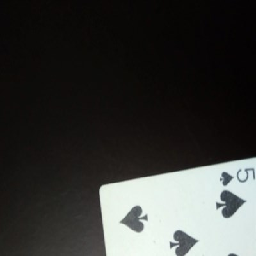

In [20]:
#推論画像の格納、配列化、表示
img = tf.keras.preprocessing.image.load_img(last_file, target_size=(256, 256, 3))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

img

In [21]:
#推論開始
%%time
result = np.argmax(new_model.predict(img_array))

UsageError: Line magic function `%%time` not found.


In [22]:
# train.csv等のgender_statusの値と等しい(gender_statusが0始まりだから)
result

NameError: name 'result' is not defined